[3b] DNN実践課題1

In [33]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # 4GPUの場合

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
from tqdm import tqdm

import time

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. [Multi GPU] マルチGPUによる学習
参考サイト：https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html

In [2]:


    
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# ネットワーク宣言
#net = models.vgg16()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,2)
        self.conv2 = nn.Conv2d(32, 64, 3,1)
        self.conv3 = nn.Conv2d(64,128,3,2)
        self.conv4 = nn.Conv2d(128,512,3,1)
        self.conv5 = nn.Conv2d(512,1024,3,2)
        
        self.pool=nn.AdaptiveAvgPool2d((1,1)) 
        self.flat=nn.Flatten()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x=  self.flat(x)
        x= F.relu(F.dropout(self.fc1(x),0.2))
        x= self.fc2(x)
        x = F.softmax(x,dim=1)
        return x
    


net = Net()
print(net(torch.zeros((1,3,32,32))))
device_num = torch.cuda.device_count()
print(device)
print("gpu数"+str(device_num))
# cuda or cpu?

net = net.to(device)
cudnn.benchmark = True
# 複数GPU使用宣言
if device_num>1:
    net = torch.nn.DataParallel(net) # make parallel
    cudnn.benchmark = True
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=8)

print(trainset[0][0].shape)

tensor([[0.1039, 0.0924, 0.1061, 0.1033, 0.0955, 0.0987, 0.0929, 0.0937, 0.1050,
         0.1085]], grad_fn=<SoftmaxBackward>)
cuda
gpu数2
Files already downloaded and verified
torch.Size([3, 32, 32])


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())#SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

start =time.time()

start_epoch=0
list_loss = []           
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        running_loss += loss.item()
        if i % 512 == 1:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        correct = 0
        total = 0
        # 勾配を記憶せず（学習せずに）に計算を行う
    with torch.no_grad():
        for data in testloader:
            images,labels=data
            images, labels = images.to(device),labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
end = time.time()
print("time:%.3f"%(end-start))

[1,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 29 %
[2,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 36 %
[3,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 39 %
[4,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 40 %
[5,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 44 %
[6,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 47 %
[7,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 46 %
[8,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 49 %
[9,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 53 %
[10,     2] loss: 0.002
Accuracy of the network on the 10000 test images: 54 %
time:55.677


|1バッチ| 1024            |    2048    |   
|---------|-------------------|----------|  
|single   |54.243，56%  | 60.214s，49%  |   
|2gpu  　   | 55.677，54%|    57.074s，50%  |

層が多く，一バッチが大きいほどgpuの効果が高く，逆の場合は一つの方が速い場合もあるとわかった．


### 2. [CNNの可視化1] Zeiler-Fergus の方法による可視化

参考ソース:https://github.com/sar-gupta/convisualize_nb

In [1]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [8]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image
labels = json.load(open('./imagenet_class_index.json'))
def predict(image):
    _, index = vgg(image).data[0].max(0)
    return index.item(), labels[str(index.item())][1]

golden_retriever


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(-0.5, 24.5, 24.5, -0.5)

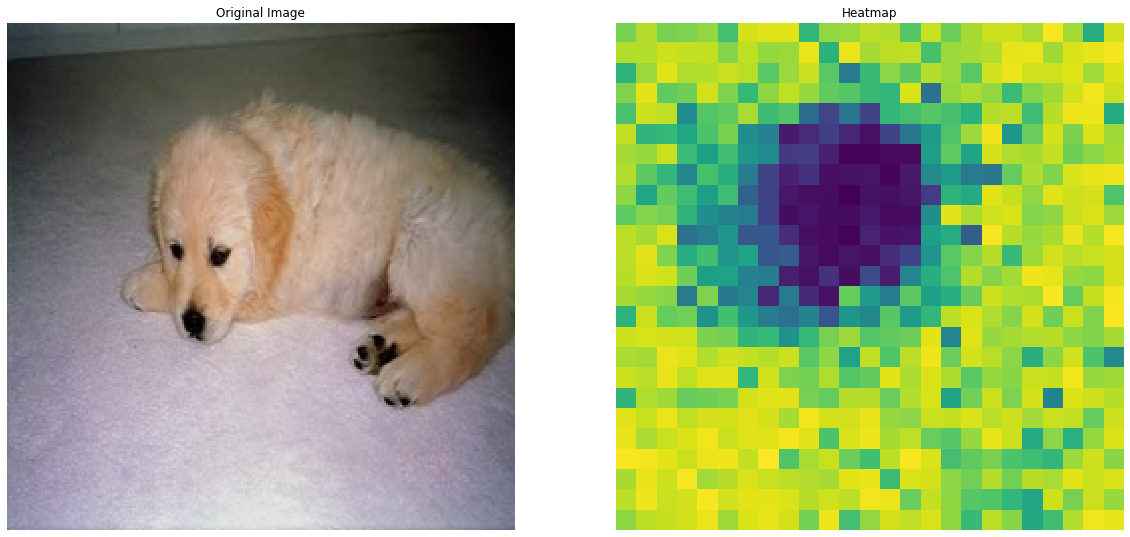

In [67]:
path="/export/data/dataset/image.cd/cd_1/photos/"
image=Image.open(path+"dogs/"+"247098.jpg")
image=normalize(image)
true_class,labelname=predict(image)
print(labelname)


k=64
stride =8
heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
image = image.data

i = 0
a = 0
while i<=image.shape[3]-k:
    j = 0 
    b = 0
    while j<=image.shape[2]-k:
        h_filter = torch.ones(image.shape)
        h_filter[:,:,j:j+k, i:i+k] = 0
        temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
        temp_softmax = vgg(temp_image)
        temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
        heatmap[a][b] = temp_softmax[true_class]
        j += stride
        b += 1
    i += stride
    a += 1

image = image.squeeze()

true_image = image.transpose(0,1)
true_image = true_image.transpose(1,2)
# Un-Normalize image
true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

# Plot both images
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20)

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(true_image.to('cpu').detach().numpy().copy())
plt.title('Original Image')
plt.axis('off') 

# Normalize heatmap
heatmap = heatmap - heatmap.min()
heatmap = heatmap/heatmap.max()
heatmap = np.uint8(255 * heatmap)

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(heatmap)
plt.title('Heatmap')
plt.axis('off') 

### 3. BPによる可視化

In [34]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

In [37]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).to(device))
    return image
labels = json.load(open('./imagenet_class_index.json'))
print(len(labels))
def predict(image):
    _, index = vgg(image).data[0].max(0)
    return index.item(), labels[str(index.item())][1]

1000


(-0.5, 255.5, 255.5, -0.5)

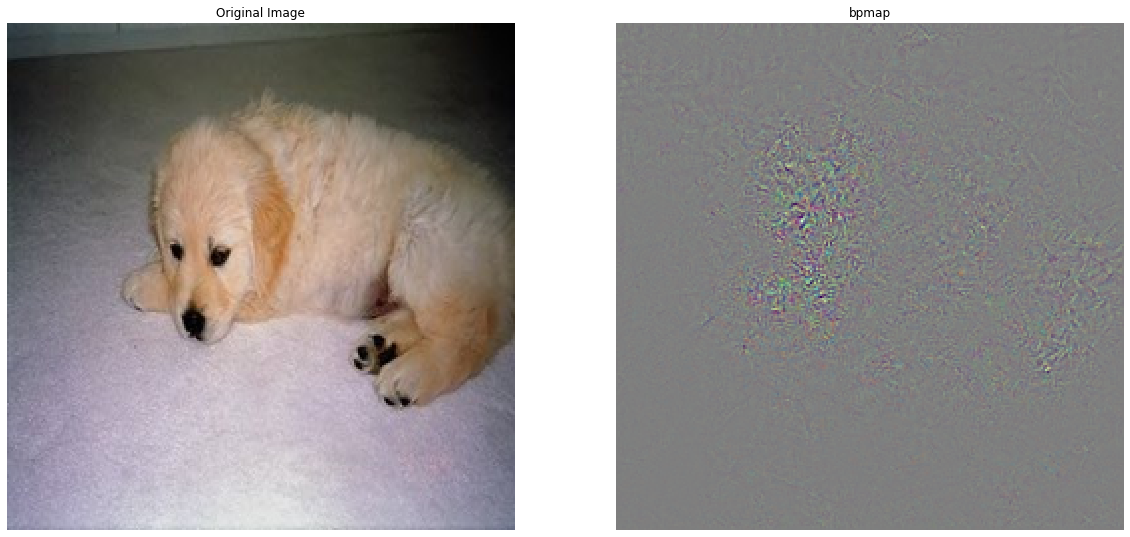

In [87]:

path="/export/data/dataset/image.cd/cd_1/photos/"
src=Image.open(path+"dogs/"+"247098.jpg")

image=normalize(src)

image.requires_grad =True
output=vgg(image)

vgg.zero_grad()
_,index=output.data[0].max(0)
one_hot=torch.zeros(1,len(labels)).to(device)

one_hot[0][index.item()]=1

output.backward(one_hot)
bpmap=image.grad[0]
bpmap=bpmap -bpmap.min()
bpmap=bpmap/(torch.max(bpmap) )


# Plot both images
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20)


a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(src.resize(image.size()[2:4]))
plt.title('Original Image')
plt.axis('off') 
# Normalize heatmap
bpmap = (bpmap.cpu().numpy())

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(bpmap.transpose(1,2,0))
plt.title('bpmap')
plt.axis('off') 

### 4. Grad-CAM

In [ ]:

path="/export/data/dataset/image.cd/cd_1/photos/"
src=Image.open(path+"dogs/"+"247098.jpg")

image=normalize(src)

image.requires_grad =True
output=vgg(image)
vgg.zero_grad()
_,index=output.data[0].max(0)


# 画像を順伝搬
_ = gcam.forward(input_data)

# 予測ラベルを元に逆伝搬し、勾配を計算
single_predicted = predicted.view(1, predicted.shape[0]).to(device)
gcam.backward(ids=index)

# 指定の層の勾配マップを取得
#(各層の名前は、print(model)で参照可能)
regions = gcam.generate("conv3")

# Plot both images
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20)


a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(src.resize(image.size()[2:4]))
plt.title('Original Image')
plt.axis('off') 
# Normalize heatmap
bpmap = (bpmap.cpu().numpy())

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(bpmap.transpose(1,2,0))
plt.title('bpmap')
plt.axis('off') 